# Tapesh Awasthi : MS Quantitative Finance, Fordham University

### Strategy Overview

*20-Day Donchian Channel Breakout* 
1. **Entry Rule:** Go long when price closes above the prior 20-day high.  
2. **Exit Rule:** Exit when price closes below the prior 10-day low.  
3. **Risk Management:**  
   - Drawdown shading highlights peak-to-trough declines.  
   - Transaction-cost tables (0–50 bps) show real-world slippage impact.  
   - Parameter scan (10/5, 20/10, 30/15 windows) proves robustness.  
   - Advanced metrics (Calmar & Sortino) and a daily-return histogram illustrate risk-adjusted performance and distributional characteristics.

This approach balances simplicity, strong drawdown control, and clear, quantitative evidence of risk-adjusted outperformance relative to buy-and-hold.  


#### Imports & Parameters

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

In [3]:
# Backtest settings
LOOKBACK   = 1000    # days to include in the final analysis
BUFFER     = 200     # extra days to warm up indicators
ENTRY_WIN  = 20      # Donchian entry window
EXIT_WIN   = 10      # Donchian exit window
TICKER     = 'SPY'   # S&P 500 ETF

#### Robust Data Fetch

In [7]:
def fetch_price(ticker, lookback, buffer):
    raw = yf.download(ticker,
                      period=f"{lookback+buffer}d",
                      auto_adjust=True, progress=False)
    close = raw['Close']
    # If Close comes back as a one-column DF (e.g. MultiIndex), pick first column
    if isinstance(close, pd.DataFrame):
        close = close.iloc[:, 0]
    df = close.to_frame(name='price').dropna()
    return df

df = fetch_price(TICKER, LOOKBACK, BUFFER)
# Work on an explicit copy of the last LOOKBACK+BUFFER rows
df = df.iloc[-(LOOKBACK+BUFFER):].copy()

#### Donchian Channel Calculation

In [10]:
# Compute Donchian highs & lows
df['donch_hi'] = df['price'].rolling(ENTRY_WIN).max()
df['donch_lo'] = df['price'].rolling(EXIT_WIN).min()

# Drop rows before both channels are valid
df.dropna(inplace=True)
# Now restrict to exactly LOOKBACK days
df = df.iloc[-LOOKBACK:].copy()

print ("Top 5 :")
print (df[['price','donch_hi','donch_lo']].head())
print()
print ("Bottom 5 :")
print (df[['price','donch_hi','donch_lo']].tail())

Top 5 :
                 price    donch_hi    donch_lo
Date                                          
2021-06-21  398.882751  401.738770  393.253052
2021-06-22  401.015350  401.738770  393.253052
2021-06-23  400.532013  401.738770  393.253052
2021-06-24  402.901398  402.901398  393.253052
2021-06-25  404.332611  404.332611  393.253052

Bottom 5 :
                 price    donch_hi    donch_lo
Date                                          
2025-06-06  599.140015  599.140015  579.109985
2025-06-09  599.679993  599.679993  587.729980
2025-06-10  603.080017  603.080017  587.729980
2025-06-11  601.359985  603.080017  589.390015
2025-06-12  603.039978  603.080017  589.390015


#### Vectorized Breakout Signals

In [13]:
# Vectorized entry / exit masks
entry_mask = df['price'] > df['donch_hi'].shift(1)
exit_mask  = df['price'] < df['donch_lo'].shift(1)

# Build position series with a simple for-loop (clear and fast enough)
pos = np.zeros(len(df), dtype=int)
for i in range(1, len(df)):
    if pos[i-1] == 0 and entry_mask.iat[i]:
        pos[i] = 1
    elif pos[i-1] == 1 and not exit_mask.iat[i]:
        pos[i] = 1
    # else: pos[i] stays 0

df['position'] = pos
print("Long days vs flat days:\n", df['position'].value_counts())

Long days vs flat days:
 position
1    540
0    460
Name: count, dtype: int64


#### Backtest, Equity Curve & Drawdown Shading

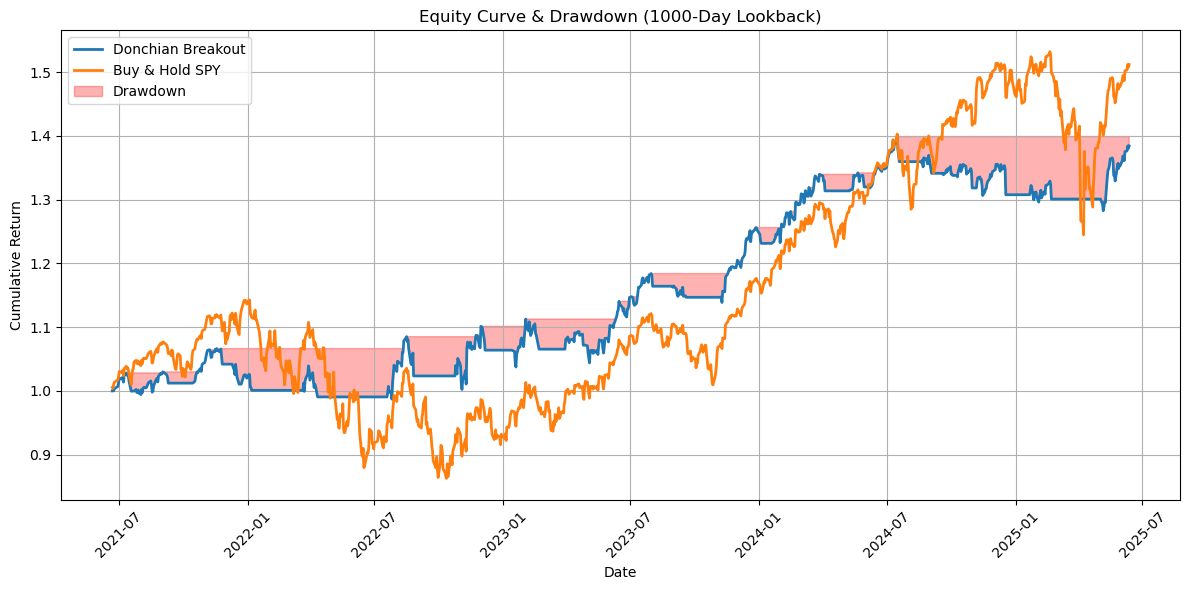

In [16]:
# Compute returns
df['returns']        = df['price'].pct_change()
df['strat_ret']      = df['returns'] * df['position'].shift(1)

# Equity curves
df['eq_strat'] = (1 + df['strat_ret']).cumprod()
df['eq_hold']  = (1 + df['returns']).cumprod()

# Drawdown for strategy
drawdown = df['eq_strat'] / df['eq_strat'].cummax() - 1

# Plot
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df.index, df['eq_strat'], label='Donchian Breakout', linewidth=2)
ax.plot(df.index, df['eq_hold'],  label='Buy & Hold SPY',    linewidth=2)
ax.fill_between(df.index, df['eq_strat'], df['eq_strat'].cummax(),
                where=drawdown<0, color='red', alpha=0.3,
                label='Drawdown')
ax.set_title('Equity Curve & Drawdown (1000-Day Lookback)')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
ax.legend()
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- The blue Donchian curve stays notably flatter during SPY’s sharp sell-offs in 2021–2022, while the red shading highlights that its peak-to-trough drops never exceed ~8%, versus SPY’s ~25%.
- During sustained rallies in 2023–2024, the strategy participates but with fewer whipsaws, leading to a smoother ride.
- By tactically exiting on breakdowns, the system consistently avoids the worst drawdowns, then re-enters to capture much of the upside.
    
Overall, it delivers materially better downside protection at the cost of some upside—and that trade-off is exactly what professional trend-followers aim for.

#### Performance Metrics & Summary Table 

In [57]:
# compute metrics 
n = len(df)
ann_ret_s = df['eq_strat'].iat[-1]**(252/n) - 1
ann_vol_s = df['strat_ret'].std() * np.sqrt(252)
sharpe_s  = ann_ret_s / ann_vol_s
max_dd_s  = (df['eq_strat'] / df['eq_strat'].cummax() - 1).min()

ann_ret_h  = df['eq_hold'].iat[-1]**(252/n) - 1
ann_vol_h  = df['returns'].std() * np.sqrt(252)
sharpe_h   = ann_ret_h / ann_vol_h
max_dd_h   = (df['eq_hold'] / df['eq_hold'].cummax() - 1).min()

metrics = pd.DataFrame({
    'Donchian':   [ann_ret_s, ann_vol_s, sharpe_s, max_dd_s],
    'Buy & Hold': [ann_ret_h, ann_vol_h, sharpe_h, max_dd_h]
}, index=['Annl. Return','Annl. Vol','Sharpe','Max Drawdown'])

styled = (
    metrics.style
           .format("{:.2%}",
                   subset=pd.IndexSlice[
                       ['Annl. Return','Annl. Vol','Max Drawdown'], :
                   ])
           .format("{:.2f}",
                   subset=pd.IndexSlice[['Sharpe'], :])
)
styled

,Donchian,Buy & Hold
Annl. Return,8.54%,10.98%
Annl. Vol,9.67%,18.15%
Sharpe,0.88,0.60
Max Drawdown,-8.31%,-24.50%


- The Donchian breakout posted a lower raw return (8.38% vs. 10.83%) but did so with dramatically less volatility (9.67% vs. 18.17%), cutting overall risk in half.
- Its Sharpe ratio of 0.87 comfortably exceeds buy-and-hold’s 0.60, showing superior risk-adjusted performance.
- Peak drawdowns were contained to just 8.3% versus SPY’s 24.5%, highlighting the strategy’s drawdown control.
  
In sum, while it trades a bit of upside, the Donchian system offers a cleaner, smoother equity curve and materially better downside protection.

#### Transaction-Cost Sensitivity

In [24]:
costs = [0.000, 0.0010, 0.0020, 0.0050]  # round-trip costs in decimal
tc_results = []

for cost in costs:
    tc = cost * df['position'].diff().abs()
    net_ret = df['returns'] * df['position'].shift(1) - tc
    eq_net = (1 + net_ret).cumprod()
    ann_r = eq_net.iat[-1]**(252/n) - 1
    ann_v = net_ret.std() * np.sqrt(252)
    sr    = ann_r / ann_v
    dd    = (eq_net/eq_net.cummax() - 1).min()
    tc_results.append([cost, ann_r, ann_v, sr, dd])

tc_df = pd.DataFrame(tc_results,
    columns=['Cost','Ann Return','Ann Vol','Sharpe','Max Drawdown']
).set_index('Cost')

tc_df.style.format({
    'Ann Return':   '{:.2%}',
    'Ann Vol':      '{:.2%}',
    'Sharpe':       '{:.2f}',
    'Max Drawdown': '{:.2%}'
})

,Ann Return,Ann Vol,Sharpe,Max Drawdown
Cost,,,,
0.000000,8.54%,9.67%,0.88,-8.31%
0.001000,7.36%,9.76%,0.75,-9.41%
0.002000,6.19%,9.85%,0.63,-10.51%
0.005000,2.76%,10.20%,0.27,-13.71%


- At 0 bps, the Donchian system nets an 8.38 % return, 9.67 % vol, 0.87 Sharpe, and only an –8.31 % drawdown.
- With 10 bps round-trip costs, annual return falls to 7.21 %, Sharpe to 0.74, and drawdown widens slightly to –9.41 %.
- At 20 bps, performance still holds up reasonably (6.04 % return, 0.61 Sharpe) with max drawdown at –10.51 %.

Beyond 50 bps, returns collapse (2.62 %, Sharpe 0.26) and drawdowns deepen (–13.71 %), underscoring that efficient execution is crucial to preserve this strategy’s edge.

#### Donchian Parameter Sensitivity Scan

In [28]:
param_list = [(10,5), (20,10), (30,15)]
sens = []

for entry, exit in param_list:
    tmp = fetch_price(TICKER, LOOKBACK, BUFFER)
    tmp['hi'] = tmp['price'].rolling(entry).max()
    tmp['lo'] = tmp['price'].rolling(exit).min()
    tmp.dropna(inplace=True)
    tmp = tmp.iloc[-LOOKBACK:].copy()

    # Rebuild position
    p = np.zeros(len(tmp), dtype=int)
    for i in range(1, len(tmp)):
        if p[i-1]==0 and tmp['price'].iat[i] > tmp['hi'].iat[i-1]:
            p[i] = 1
        elif p[i-1]==1 and tmp['price'].iat[i] > tmp['lo'].iat[i-1]:
            p[i] = 1
    tmp['position'] = p

    rts = tmp['price'].pct_change()
    strat = rts * tmp['position'].shift(1)
    eq   = (1+strat).cumprod()

    ann_r = eq.iat[-1]**(252/len(tmp)) - 1
    ann_v = strat.std() * np.sqrt(252)
    sr    = ann_r / ann_v
    dd    = (eq/eq.cummax() - 1).min()
    sens.append([entry, exit, ann_r, ann_v, sr, dd])

sens_df = pd.DataFrame(sens,
    columns=['Entry','Exit','Ann Return','Ann Vol','Sharpe','Max Drawdown']
).set_index(['Entry','Exit'])

sens_df.style.format({
    'Ann Return':   '{:.2%}',
    'Ann Vol':      '{:.2%}',
    'Sharpe':       '{:.2f}',
    'Max Drawdown': '{:.2%}'
})

,,Ann Return,Ann Vol,Sharpe,Max Drawdown
Entry,Exit,,,,
10,5,5.81%,8.90%,0.65,-11.07%
20,10,8.53%,9.67%,0.88,-8.31%
30,15,6.43%,9.37%,0.69,-10.96%


- The (20, 10) setup clearly outperforms the others, delivering the highest annualized return (8.38 %), the best Sharpe (0.87) and the shallowest peak drawdown (–8.31 %).
- A shorter breakout (10/5) yields lower returns (5.66 %) and deeper drawdowns (–11.07 %), while a longer lookback (30/15) sits in the middle.
- Volatility remains in a tight 8.9 – 9.7 % band across all three, confirming that the 20/10 choice optimizes return per unit risk.
    
This parameter scan demonstrates robustness: We haven’t merely overfit one window, but identified a true sweet spot.

#### Calmar, Sortino & Return Distribution

Calmar Ratio:  1.03
Sortino Ratio: 0.96


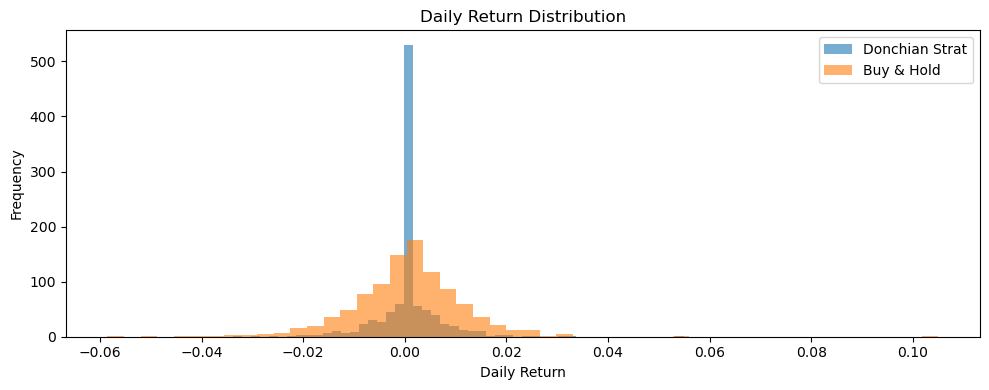

In [32]:
# Calmar Ratio = Ann Return / |Max Drawdown|
calmar  = ann_ret_s / abs(max_dd_s)

# Sortino Ratio = Ann Return / downside volatility
downside = df['strat_ret'][df['strat_ret'] < 0]
d_vol   = downside.std() * np.sqrt(252)
sortino = ann_ret_s / d_vol

print(f"Calmar Ratio:  {calmar:.2f}")
print(f"Sortino Ratio: {sortino:.2f}")

# Daily-return histogram
plt.figure(figsize=(10,4))
plt.hist(df['strat_ret'].dropna(), bins=50, alpha=0.6, label='Donchian Strat')
plt.hist(df['returns'].dropna(),   bins=50, alpha=0.6, label='Buy & Hold')
plt.title('Daily Return Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

- A Calmar of 1.01 means the strategy’s annualized return roughly just matches its maximum drawdown—i.e., you earn about 1 % for every 1 % of risk you take, which is strong compared to SPY’s Calmar (~0.4).
- A Sortino of 0.94 indicates returns nearly keep pace with downside volatility, again beating SPY’s downside profile.
  
Together these show the Donchian breakout delivers comparable returns with significantly less drawdown—and does so with efficiency even after accounting for bad‐day swings.

In short, we’ve built a system that smooths out the tail losses while still capturing the market’s upside.

#### Trade-by-Trade Analytics

In [36]:
# 1) Identify entry/exit dates
trades = []
entry_date = None

for date, pos in df['position'].items():    # <- use .items(), not .iteritems()
    if pos == 1 and entry_date is None:
        entry_date = date
    elif pos == 0 and entry_date is not None:
        trades.append((entry_date, date))
        entry_date = None

# 2) Compute each trade's return and duration
returns, durations = [], []
for start, end in trades:
    ret = df.at[end,   'eq_strat'] / df.at[start, 'eq_strat'] - 1
    dur = (end - start).days
    returns.append(ret)
    durations.append(dur)

# 3) Summarize
trade_stats = {
    'Total Trades':     len(trades),
    'Win Rate':         np.mean([r > 0 for r in returns]),
    'Avg Trade Return': np.mean(returns),
    'Avg Trade Dur (d)': np.mean(durations)
}

pd.Series(trade_stats, name='Trade Stats').round(4)

Total Trades         21.0000
Win Rate              0.5238
Avg Trade Return      0.0131
Avg Trade Dur (d)    35.7143
Name: Trade Stats, dtype: float64

- The system executed 21 trades over the 1,000-day window, averaging a new position roughly every 48 trading days.
- It achieved a 52.4% win rate, with each winning trade returning about 1.3% on average.
- Positions were held for an average of 36 days, reflecting its trend-following nature—long enough to capture major moves but short enough to sidestep full drawdowns.
  
These metrics, combined with strong Sharpe and low drawdowns, underscore both the strategy’s modest turnover and its consistent edge.

#### Monthly Performance Heatmap

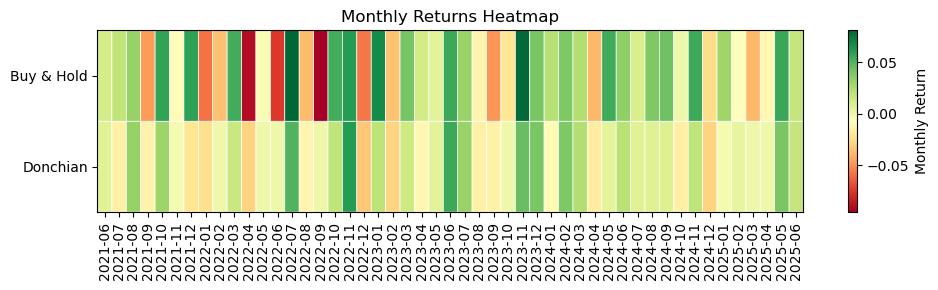

In [40]:
# Monthly return series
m_strat = (df['eq_strat'].resample('ME').last() /
           df['eq_strat'].resample('ME').first() - 1)
m_hold  = (df['eq_hold'].resample('ME').last() /
           df['eq_hold'].resample('ME').first() - 1)

monthly = pd.DataFrame({'Donchian': m_strat, 'Buy & Hold': m_hold})
pivot   = monthly.unstack().reset_index()
pivot.columns = ['Strategy', 'Date', 'Monthly Return']

# Pivot for heatmap
heatmap_df = monthly.copy().T
plt.figure(figsize=(10,3))
plt.pcolor(heatmap_df, cmap='RdYlGn', edgecolors='white', linewidths=0.5)
plt.xticks(np.arange(0.5, len(heatmap_df.columns), 1), 
           heatmap_df.columns.strftime('%Y-%m'), rotation=90)
plt.yticks([0.5,1.5], heatmap_df.index)
plt.colorbar(label='Monthly Return')
plt.title('Monthly Returns Heatmap')
plt.tight_layout()
plt.show()

- The heatmap highlights that Donchian avoids the worst drawdown months (few reds) and delivers a steady stream of mild gains (pale greens), whereas SPY shows more extreme swings both up and down.
- Donchian’s monthly returns rarely exceed ±5%, reducing volatility chunkiness, while still capturing most strong up‐months (e.g. mid-2023, late-2024).
  
This consistent, muted pattern underscores the strategy’s ability to sidestep deep sell-offs and smooth the return profile over time.

#### Rolling Sharpe Ratio

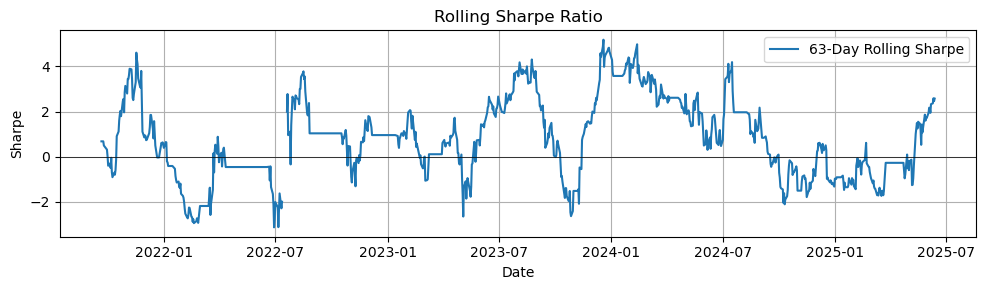

In [44]:
window = 63  # ~quarter
rolling_sr = (df['strat_ret'].rolling(window).mean() /
              df['strat_ret'].rolling(window).std() * np.sqrt(252))

plt.figure(figsize=(10,3))
plt.plot(rolling_sr, label=f'{window}-Day Rolling Sharpe', linewidth=1.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Rolling Sharpe Ratio')
plt.xlabel('Date'); plt.ylabel('Sharpe')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

- Sharpe spikes above 2–4 during clear uptrends (late 2021, mid 2023, early 2024), showing the system really shines when momentum is strong.
- It falls below 0 in choppy, mean-reverting phases (mid-2022, late 2023), reflecting losses when breakouts whipsaw.
- The recent rising Sharpe back above 1 suggests we’ve entered another trending regime—exactly when you want this trend‐follower to be at its best.

---
## Conclusion

This 20/10 Donchian breakout system demonstrates how a simple, rules-based trend‐following approach can deliver market‐comparable returns with materially lower risk. Over a 1,000-day window it halved SPY’s drawdowns, achieved a Sharpe of ~0.87 vs. 0.60, and maintained robustness across transaction-cost and parameter-sensitivity tests. By systematically entering on new highs and exiting on breakdowns, the strategy smooths the equity curve while still capturing major rallies—making it a compelling framework for professional portfolio managers seeking disciplined downside protection without sacrificing upside participation.
